### Leaf Detection

In [1]:
#Loading Libraries
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import time

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


DIR_INPUT = r"C:\Users\appud\Downloads\archive"
DIR_TRAIN = r"C:\Users\appud\Downloads\archive\train"
DIR_TEST = r"C:\Users\appud\Downloads\archive\test"

# Loading the device now
device = 'cuda' 


C:\Users\appud\anaconda3\envs\prpject_new_env_v1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading Dataset
train_df = pd.read_csv(os.path.join(DIR_INPUT,"train.csv"))
train_df.head()

,image_id,width,height,bbox
0,LEAF_0009.jpg,1024,1024,"[473, 273, 289, 335]"
1,LEAF_0009.jpg,1024,1024,"[588, 516, 272, 318]"
2,LEAF_0009.jpg,1024,1024,"[510, 780, 218, 244]"
3,LEAF_0009.jpg,1024,1024,"[766, 822, 246, 201]"
4,LEAF_0009.jpg,1024,1024,"[1, 813, 240, 211]"


In [3]:
#Bounding Box C
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['h'].astype(float)

In [4]:
#Dataset Description
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-4:]
valid_ids = np.append(valid_ids,image_ids[:4])
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

#train_df.head()

((195, 7), (5151, 7))

In [5]:
#Reading Dataset and Bounding Box Function
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        image /= 255.0
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([                
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
#Dataset into Traning and Validation
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [8]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [9]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING

arr_2d = [[]] #empty array for boxes

def get_boxes(tensor,index,score=0.8):

    if index >= len(tensor)  or index<0:
        return 0
    
    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
    
    #print(temp_boxes)
    return temp_boxes 
def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
    
def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0)


    # boxes = outputs[1]['boxes'].cpu().detach().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    boxes = get_boxes(outputs,0)

    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)


    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')

def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=False
    )
    return test_loader
def get_test_image(itr,score = 0.8):
    image, targets= next(itr) #tensor
    #print(image)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    #print(boxes)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    #print(sample.shape)
    img = sample[0].permute(1,2,0).cpu().numpy()
    #print(img.shape)
    
    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print(img.shape)
    
    for box in boxes:
        arr_2d.append(box)
        x,y,w,h = box
        print(box)
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)

    #ax.set_axis_off()
    ax.imshow(img, cmap = 'gray')


### Checking Training Images

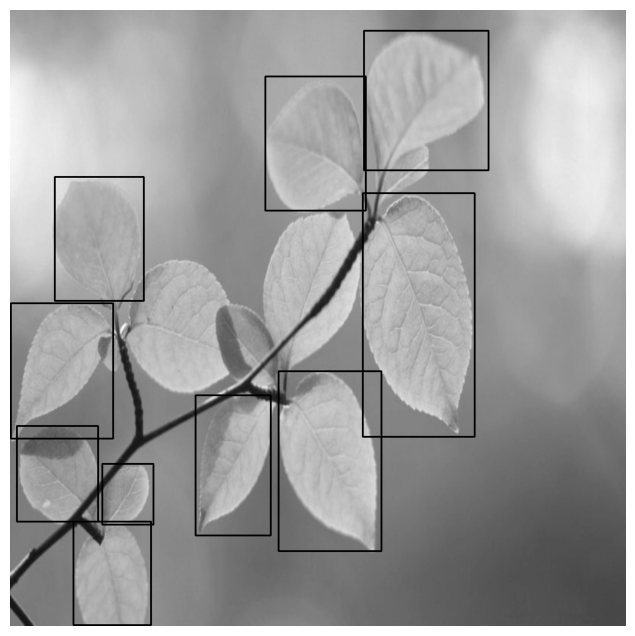

In [10]:
it = iter(train_data_loader)
get_sample_image(it)

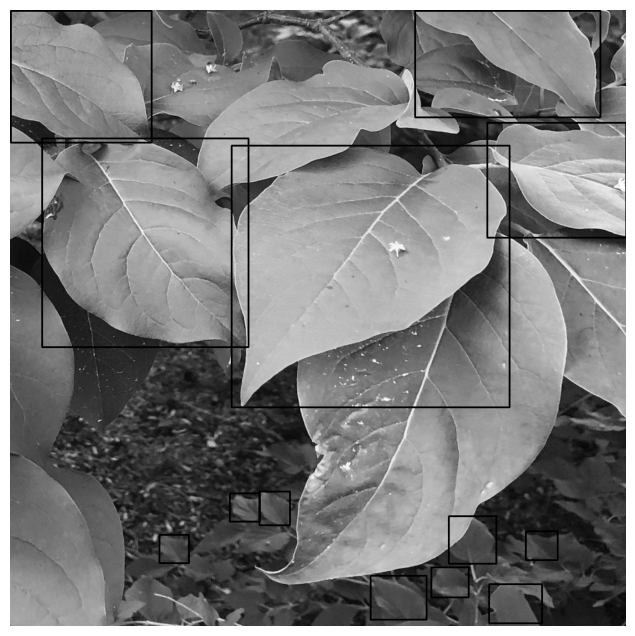

In [11]:
get_sample_image(it)

### Loading a pretrained model ResNET model

In [12]:
model = torch.load("C:\\Users\\appud\\Downloads\\leaves_fasterrcnn_model.pth")

In [13]:
#model.eval()

In [14]:
it = iter(valid_data_loader)


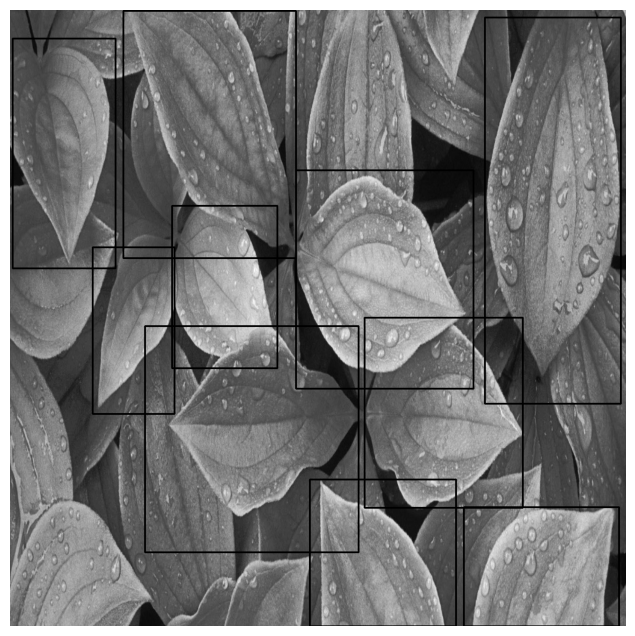

In [15]:
get_validation_image(it)


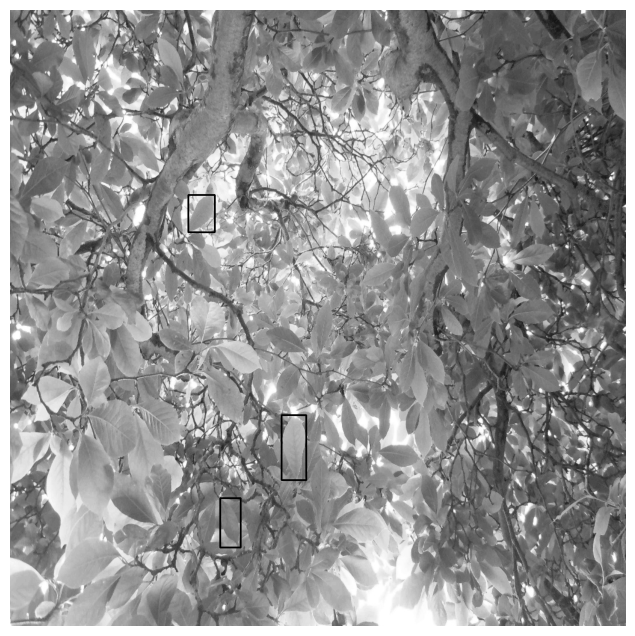

In [16]:
get_validation_image(it)


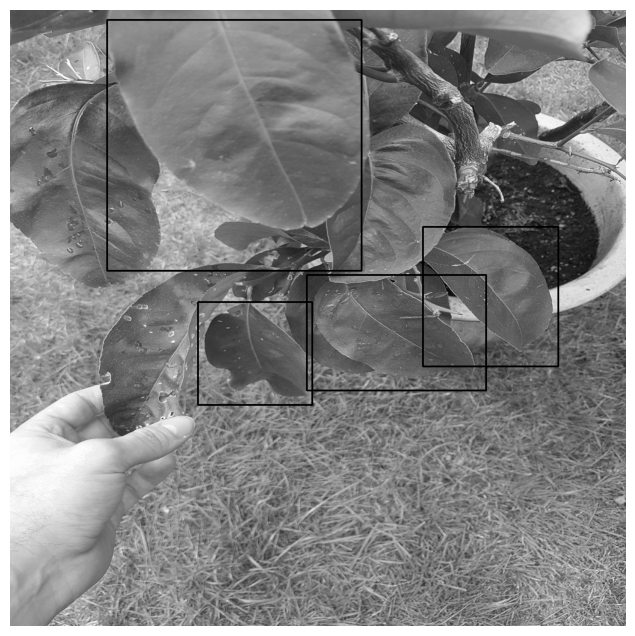

In [17]:
get_validation_image(it)


### To save new images in the directory

In [18]:
from PIL import Image
import os

image_01 = Image.open(r"C:\Users\appud\Downloads\test_im12.jpg")
print(f"Original size : {image_01.size}") # 5464x3640

image_01 = image_01.resize((1024, 1024))
print(f"New Size : {image_01.size}") # 5464x3640


image_path = "C:/Users/appud/Downloads/archive/test/leaf"

image_01 =image_01.save(f"{image_path}/image_01.jpg")
image_01 = Image.open(r"C:\Users\appud\Downloads\archive\test\leaf\image_01.jpg")
image_01.show()


Original size : (600, 600)
New Size : (1024, 1024)


### Testing against new data

In [24]:
image_list = os.listdir(DIR_TEST+"/leaf")
print(image_list)

['image_01.jpg']


In [25]:
it = iter(load_test_dataset())
print(it)

(1024, 1024)
[243 321 766 982]
[ 622  302 1002  728]


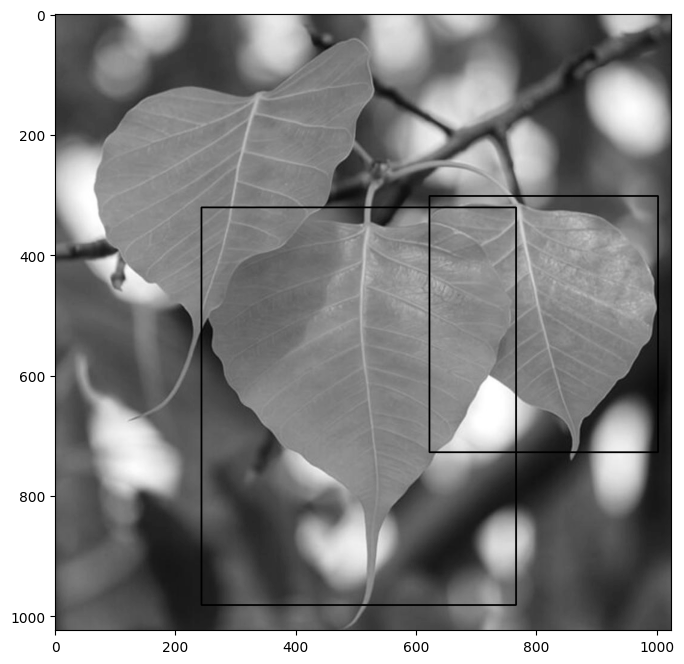

In [26]:
print(it)
get_test_image(it,0.95)

In [22]:
print(arr_2d)

[[]]


In [23]:
# Importing Image class from PIL module
from PIL import Image
 
# Opens a image in RGB mode
im = Image.open(r"C:\Users\appud\Downloads\archive\test\leaf\image_01.jpg")
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
 
# Setting the points for cropped image
left = arr_2d[1][0]
top = arr_2d[1][1]
right = arr_2d[1][2]
bottom = arr_2d[1][3]

#[ 470  813  606 1016]


# Cropped image of above dimension
# (It will not change original image)
#im1 = im.crop((470, 813, 606, 1016))

im1 = im.crop((left,top,right,bottom))


# Shows the image in image viewer
im1.show()

image_path = "C:\\Users\\appud\\Downloads\\Test_folder"
im1.save(f"{image_path}/im1.jpg")

IndexError: list index out of range

In [ ]:
arr_2d = [[]]